In [1]:
from numpy import *
import numpy as np
from scipy.optimize import minimize
from scipy.optimize import LinearConstraint
from scipy.special import *
from scipy.spatial.distance import cdist
import warnings

In [3]:
# a list of drones, each element containing two tuples, representing the coordinates of the initial deployment position
# and the destination coordinates respectively
drones=[((35.0,32),(10.0,30),0),
        ((40.0,15),(8.0,3),0),
        ((20.0,4),(10.0,30),0),
        ((6.0,20),(38.0,22),0)]
# a list of initial location of charging stations, could be random. the size of 
# the list determines the number of charging stations
# stations=array([[25.0,25],
#           [30.0,15],
#           [13.0,13]])
stations=array([[0.0,0],
          [0.0,0],
          [0.0,0]])

In [4]:
my_inf=1e6
def my_log(m):
    res = log(m, out=np.zeros_like(m), where=(m>0))
    return res
class drone_env:
    def __init__(self,drones,stations) -> None:
        super().__init__()
        self.drones=drones
        self.stations=stations
        self.N_drones= len(drones)
        self.N_stations=len(stations)
        self.stage_horizon=self.N_stations+1
        self.gamma_k_length=self.N_stations+1
        return
    
    def return_stagewise_cost(self,params): #params is like stations
        
        D_ss=[0]*self.N_drones
        for drone_id,drone in enumerate(self.drones):
            stage=concatenate((params,array(self.drones[drone_id][1]).reshape(1,-1)),axis=0)
            D_s=[0]*(self.stage_horizon+1)
            stage_0=array(self.drones[drone_id][0]).reshape(1,-1)
            D_s[0]=cdist(stage_0,stage,'sqeuclidean')
            D_s[0][0,-1]=0.0+(self.drones[drone_id][2]==0)*my_inf
            delta_id= self.N_stations+drone_id
            # so far we have taken care of the first distance matrix
            d=cdist(stage,stage,'sqeuclidean')
            d=d+diag([my_inf]*self.gamma_k_length)
            d[-1,:]=[my_inf]*self.gamma_k_length
            d[-1,-1]=0.0
            for i in range(1,self.stage_horizon):
                D_s[i]=d
            d=[my_inf]*(self.gamma_k_length-1)
            d.append(0.0)
            D_s[-1]=array(d).reshape(-1,1)
            D_ss[drone_id]=D_s
        self.D_ss=D_ss
        return
    def calc_associations(self,beta):
        p=[]
        D_ss=self.D_ss
        for D_s in D_ss:
            K=len(D_s)
            D=D_s[::-1]
            out_D=[0]*(K+1)
            out_D[0]=array([0.0]).reshape(-1,1)
            out_p=[0]*(K+1)
            out_p[0]=array([1.0]).reshape(-1,1)
            out=[0]*(K+1)
            out[0]=array([1.0]).reshape(-1,1)
            for i in range(1,K+1):
                out_D[i]=(D[i-1]+repeat(transpose(out_D[i-1]),D[i-1].shape[0],axis=0))
                m=out_D[i].min(axis=1,keepdims=True)
                exp_D=exp(multiply(-beta,out_D[i]-m))
                out[i]=sum(multiply(exp_D,tile(out[i-1], (1,D[i-1].shape[0])).T),axis=1,keepdims=True)
                out_p[i]=divide(multiply(exp_D,out[i-1].T),out[i])
                out_D[i]=m
            p.append(out_p[::-1][:-1])
        self.P_ss=p
        return
    def free_energy(self,D_s,P_s,beta):
        '''
        input: D_s: a list of K numpy arrays corrosponding to distances between stages
        P_s: a list of K numpy arrays corrosponding to probabilities between stages

        output: out_c: K+1 numpy arrays with shape[1]=1, indicating the total cost of nodes
        '''
        K=len(D_s)
        D=D_s[::-1]
        P=P_s[::-1]
        out_P=[0]*(K+1)
        out_C=[0]*(K+1)
        out_H=[0]*(K+1)
        out_P[0]=array([1.0]).reshape(-1,1)
        out_C[0]=array([0.0]).reshape(-1,1)
        out_H[0]=array([0.0]).reshape(-1,1)
        for i in range(1,K+1):
          # assigning P of each node for calculating C in the next i
          out_P[i]=(P[i-1]*repeat(transpose(out_P[i-1]),P[i-1].shape[0],axis=0)).sum(axis=1).reshape(-1,1)
          out_C[i]=(P[i-1]*(D[i-1]*repeat(transpose(out_P[i-1]),D[i-1].shape[0],axis=0)+repeat(transpose(out_C[i-1]),D[i-1].shape[0],axis=0))).sum(axis=1).reshape(-1,1)
          out_H[i]=-(P[i-1]*(my_log(P[i-1])*repeat(transpose(out_P[i-1]),D[i-1].shape[0],axis=0)-repeat(transpose(out_H[i-1]),D[i-1].shape[0],axis=0))).sum(axis=1).reshape(-1,1)
          
        # D-1/beta*H
        return (out_C[-1].T).sum() + (-1/beta)*(out_H[-1].T).sum()
    def objective(self,params,beta):
        self.return_stagewise_cost(params.reshape(-1,2))
        cost=0
        for i in range(len(self.D_ss)):
            cost+=self.free_energy(self.D_ss[i],self.P_ss[i],beta)
        return cost
    def optimize_D(self,init_guess,beta):
        result = minimize(self.objective, init_guess,args=(beta,))#,method='nelder-mead'
        self.params = result.x
        self.return_stagewise_cost(self.params.reshape(-1,2))
        #print(result.fun)
    def train(self,beta_init=1e-6,beta_f=100,alpha=1.1):
        self.return_stagewise_cost(self.stations)
        beta=beta_init
        init_guess=ndarray.flatten(self.stations)
        while beta <= beta_f:
            count=0
            while True:
                self.calc_associations(beta) #based on D_ss
                self.optimize_D(init_guess,beta) #based on P_ss
                #print(self.params)
                if linalg.norm(self.params-init_guess) <=1e-5:
                  break
                init_guess=self.params
                count+=1
            print(f'Beta: {beta}  epoches: {count}')
            beta=beta*alpha

In [5]:
env=drone_env(drones,stations)
env.train()

Beta: 1e-06  epoches: 3
Beta: 1.1e-06  epoches: 2
Beta: 1.21e-06  epoches: 4
Beta: 1.3310000000000003e-06  epoches: 1
Beta: 1.4641000000000003e-06  epoches: 8
Beta: 1.6105100000000006e-06  epoches: 4
Beta: 1.7715610000000007e-06  epoches: 4
Beta: 1.948717100000001e-06  epoches: 1
Beta: 2.1435888100000012e-06  epoches: 2
Beta: 2.3579476910000015e-06  epoches: 4
Beta: 2.5937424601000017e-06  epoches: 1
Beta: 2.853116706110002e-06  epoches: 1
Beta: 3.1384283767210024e-06  epoches: 2
Beta: 3.452271214393103e-06  epoches: 3
Beta: 3.7974983358324136e-06  epoches: 2
Beta: 4.177248169415655e-06  epoches: 2
Beta: 4.594972986357221e-06  epoches: 1
Beta: 5.0544702849929435e-06  epoches: 3
Beta: 5.559917313492238e-06  epoches: 2
Beta: 6.115909044841462e-06  epoches: 2
Beta: 6.727499949325609e-06  epoches: 0
Beta: 7.40024994425817e-06  epoches: 2
Beta: 8.140274938683989e-06  epoches: 2
Beta: 8.954302432552388e-06  epoches: 0
Beta: 9.849732675807628e-06  epoches: 0
Beta: 1.0834705943388392e-05  epoc

In [6]:
O=[]
for i in range(env.N_drones):
  m=0
  o=[]
  for p in env.P_ss[i]:
      m=argmax(p[m,:])
      o.append(m)
  o.pop()
  O.append(o)


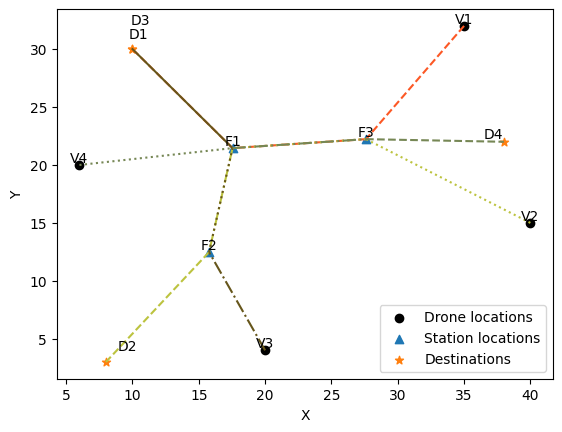

In [9]:
from matplotlib import pyplot as plt
state_locs=env.params.reshape(-1,2)
drone_locs=array([i[0] for i in env.drones])
dest_locs=array([i[1] for i in env.drones])
plt.scatter(drone_locs[:,0],drone_locs[:,1],color='black',label='Drone locations')
for i, loc in enumerate(drone_locs):
    plt.text(loc[0], loc[1], 'V'+str(i+1), ha='center', va='bottom')
plt.scatter(state_locs[:,0],state_locs[:,1],marker='^',label='Station locations')
for i, loc in enumerate(state_locs):
    plt.text(loc[0], loc[1], 'F'+str(i+1), ha='center', va='bottom')
plt.scatter(dest_locs[:,0],dest_locs[:,1],marker='*',label='Destinations')
for i, loc in enumerate(dest_locs):
    plt.text(loc[0]+2*random.rand()*(-1)**round(random.rand()), loc[1]+2*random.rand(), 'D'+str(i+1), ha='center', va='bottom')
options = ['-', '--', '-.', ':',]
for i, o in enumerate(O):
    drone_loc = drone_locs[i]
    try:
      state_loc = state_locs[o[0]]
    except:
      state_loc=dest_locs[i]
    color=random.rand(3)
    # Draw a line between drone_loc and state_loc
    plt.plot([drone_loc[0], state_loc[0]], [drone_loc[1], state_loc[1]], color=color,linewidth=1.5,linestyle=random.choice(options))
    
    # Draw lines between each two elements in o
    if len(o)>1:
      for j in range(len(o) - 1):
          try:
            loc1 = state_locs[o[j]]
          except:
            loc1 = dest_locs[i]
          try:
            loc2 = state_locs[o[j + 1]]
          except:
            loc2=dest_locs[i]
          # Draw a line between loc1 and loc2
          plt.plot([loc1[0], loc2[0]], [loc1[1], loc2[1]], color=color,linewidth=1.5,linestyle=random.choice(options))

# Set axis labels and legend
plt.xlabel('X')
plt.ylabel('Y')
plt.legend()

# Display the plot
plt.show()

In [8]:
for i,o in enumerate(O):
  print(f'\nDrone{i+1} --->', end='')
  for j in o:
    if j<env.N_stations:
      print(f'f{j+1} --->', end='')
    else:
      print(f'[D{i+1}]', end='')


Drone1 --->f3 --->f1 --->[D1][D1]
Drone2 --->f3 --->f1 --->f2 --->[D2]
Drone3 --->f2 --->f1 --->[D3][D3]
Drone4 --->f1 --->f3 --->[D4][D4]

In [27]:
env.D_ss[1][1]

array([[1.00000000e+06, 8.37339519e+01, 1.01812893e+02, 4.31685993e+02],
       [8.37339519e+01, 1.00000000e+06, 2.35090229e+02, 1.50234064e+02],
       [1.01812893e+02, 2.35090229e+02, 1.00000000e+06, 7.54085713e+02],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00]])

In [8]:
# my_inf=100
# def my_log(m):
#     res = log(m, out=np.zeros_like(m), where=(m>0))
#     return res
# class drone_env:
#     def __init__(self,drones,stations) -> None:
#         super().__init__()
#         self.drones=drones
#         self.stations=stations
#         self.N_drones= len(drones)
#         self.N_stations=len(stations)
#         self.stage_horizon=self.N_stations+1
#         self.gamma_k_length=self.N_stations+self.N_drones
#         return
    
#     def return_stagewise_cost(self,params): #params is like stations
#         stage=concatenate((params,array([i[1] for i in self.drones])),axis=0)
#         D_ss=[0]*self.N_drones
#         for drone_id,drone in enumerate(self.drones):
#             D_s=[0]*self.stage_horizon
#             stage_0=array(self.drones[drone_id][0]).reshape(1,-1)
#             D_s[0]=cdist(stage_0,stage)
#             delta_id= self.N_stations+drone_id
#             for i in range(self.N_stations,self.gamma_k_length):
#                 if i==delta_id:
#                     continue
#                 else:
#                     D_s[0][0,i]=my_inf
#             # so far we have taken care of the first distance matrix
#             d=cdist(stage,stage)
#             for i in range(self.N_stations,self.gamma_k_length):
#                 if i==delta_id:
#                     arr=[my_inf]*self.gamma_k_length
#                     arr[delta_id]=0.0
#                     d[i,:]=arr
#                 else:
#                     arr=[my_inf]*self.gamma_k_length
#                     d[i,:]=arr   
#             for j in range(self.N_stations,self.gamma_k_length):
#                 if j==delta_id:
#                     continue
#                 else:
#                     d[:self.N_stations,j]=([my_inf]*self.N_stations)
#             for i in range(1,self.stage_horizon):
#                 D_s[i]=d
#             D_ss[drone_id]=D_s
#         self.D_ss=D_ss
#         return
#     def calc_associations(self,beta):
#         p=[]
#         D_ss=self.D_ss
#         for D_s in D_ss:
#             K=len(D_s)
#             D=D_s[::-1]
#             out_D=[0]*(K+1)
#             out_D[0]=array([0.0]).reshape(-1,1)
#             out_p=[0]*(K+1)
#             out_p[0]=array([1.0]).reshape(-1,1)
#             out=[0]*(K+1)
#             out[0]=array([1.0]).reshape(-1,1)
#             for i in range(1,K+1):
#                 out_D[i]=(D[i-1]+repeat(transpose(out_D[i-1]),D[i-1].shape[0],axis=0))
#                 m=out_D[i].min(axis=1,keepdims=True)
#                 exp_D=exp(multiply(-beta,out_D[i]-m))
#                 out[i]=sum(multiply(exp_D,tile(out[i-1], (1,D[i-1].shape[0])).T),axis=1,keepdims=True)
#                 out_p[i]=divide(multiply(exp_D,out[i-1].T),out[i])
#                 out_D[i]=m
#             p.append(out_p[::-1])
#         self.P_ss=p
#         return
#     def free_energy(self,D_s,P_s,beta):
#         '''
#         input: D_s: a list of K numpy arrays corrosponding to distances between stages
#         P_s: a list of K numpy arrays corrosponding to probabilities between stages

#         output: out_c: K+1 numpy arrays with shape[1]=1, indicating the total cost of nodes
#         '''
#         K=len(D_s)
#         D=D_s[::-1]
#         P=P_s[::-1]
#         out_P=[0]*(K+1)
#         out_C=[0]*(K+1)
#         out_H=[0]*(K+1)
#         out_P[0]=array([1.0]).reshape(-1,1)
#         out_C[0]=array([0.0]).reshape(-1,1)
#         out_H[0]=array([0.0]).reshape(-1,1)
#         for i in range(1,K+1):
#           # assigning P of each node for calculating C in the next i
#           out_P[i]=(P[i-1]*repeat(transpose(out_P[i-1]),P[i-1].shape[0],axis=0)).sum(axis=1).reshape(-1,1)
#           out_C[i]=(P[i-1]*(D[i-1]*repeat(transpose(out_P[i-1]),D[i-1].shape[0],axis=0)+repeat(transpose(out_C[i-1]),D[i-1].shape[0],axis=0))).sum(axis=1).reshape(-1,1)
#           out_H[i]=-(P[i-1]*(my_log(P[i-1])*repeat(transpose(out_P[i-1]),D[i-1].shape[0],axis=0)-repeat(transpose(out_H[i-1]),D[i-1].shape[0],axis=0))).sum(axis=1).reshape(-1,1)
          
#         # D-1/beta*H
#         return (out_C[-1].T).sum() + (-1/beta)*(out_H[-1].T).sum()
#     def objective(self,params,beta):
#         self.return_stagewise_cost(params.reshape(-1,2))
#         cost=0
#         for i in range(len(self.D_ss)):
#             cost+=self.free_energy(self.D_ss[i],self.P_ss[i],beta)
#         return cost
#     def optimize_D(self,init_guess,beta):
#         result = minimize(self.objective, init_guess,args=(beta,),method='Nelder-Mead')
#         self.params = result.x
#         self.return_stagewise_cost(self.params.reshape(-1,2))
        
#     def train(self,beta_init=1e-6,beta_f=1e6,alpha=1.1):
#         self.return_stagewise_cost(self.stations)
#         beta=beta_init
#         init_guess=ndarray.flatten(repeat(self.stations.mean(axis=0,keepdims=True),self.N_stations,axis=0))
#         while beta <= beta_f:
#             count=0
#             while True:
#                 self.calc_associations(beta) #based on D_ss
#                 self.optimize_D(init_guess,beta) #based on P_ss
#                 if linalg.norm(self.params-init_guess) <=1e-4:
#                   break
#                 init_guess=self.params
#                 count+=1
#             print(f'Beta: {beta}  epoches: {count}')
#             beta=beta*alpha



        



      